In [120]:
import os
import seaborn as sns
import librosa
import xgboost as xgb
import librosa.display
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import numpy as np
from yellowbrick.model_selection import ValidationCurve
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


**DATA EXCTRACTION:**

In [121]:
data_folder = r"C:\Users\HP\Desktop\machine_learning_final_project\genres"
file_path = r"C:\Users\HP\Desktop\machine_learning_final_project\genres\blues\blues.00000.au"


In [ ]:
def extract mel(audio_file,mfccs):
    audio, sr = librosa.load(audio_file, sr=None)
    

In [122]:

def extract_features(file_path):
    try:
        # Load audio file with librosa
        audio, sr = librosa.load(file_path, res_type='kaiser_fast')

        #Visual representation of the spectrum of frequencies in a sound signal as they vary with time
        #Provides information about the frequency content of the audio signal over time. 
        #Peaks or patterns in the spectrogram can indicate the presence 
        #of specific musical notes, instruments, or other sound characteristics.
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)


        # representation of the energy distribution of pitch classes
        # it tells you about the presence and strength of different musical notes
        #disregarding their octave.It helps identify chords, key changes, and tonal characteristics.
        chromagram = librosa.feature.chroma_stft(y=audio, sr=sr)

        
        #MFCCs are coefficients representing the short-term power spectrum of a sound signal
        #MFCCs are computed on a mel-frequency scale, which approximates the human ear's response to different frequencies.
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=18)
        
        zero_crossing = librosa.feature.zero_crossing_rate(y=audio)
        
        tempo = librosa.feature.tempo(y=audio, sr=sr)
        
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
         
        spectral_bw = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0]
        
        stft = librosa.amplitude_to_db(np.abs(librosa.stft(y=audio)), ref=np.max)

        spectral_rolloff= librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
        
        
        return spectrogram, chromagram, mfccs, tempo, zero_crossing, spectral_centroid, spectral_bw, stft, spectral_rolloff,sr

    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None, None, None


In [123]:
import matplotlib.pyplot as plt
import librosa.display

def visualize_features(spectrogram, chromagram, mfccs, zero_crossings, tempo, spectral_centroids, spectral_bandwidth, spectral_rolloff, stft, sr):
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), y_axis='mel', x_axis='time', sr=sr)
    plt.title('Spectrogram')
    plt.show()

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time', sr=sr)
    plt.title('Chromagram')
    plt.show()

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time', sr=sr)
    plt.title('MFCCs')
    plt.show()

    sns.set_palette("husl")

    # Plot for Zero Crossings
    plt.figure(figsize=(10, 4))
    times_zero_crossings = librosa.times_like(zero_crossings[0], sr=sr)
    plt.plot(times_zero_crossings, zero_crossings[0], label='Zero Crossings', color='blue')
    plt.title('Zero Crossings')
    plt.legend()
    plt.show()

    # Plot for Spectral bandwidth
    plt.figure(figsize=(10, 4))
    times_spectral_bd = librosa.times_like(spectral_bandwidth, sr=sr)
    plt.plot(times_spectral_bd, spectral_bandwidth, label='Spectral Bandwindth', color='red')
    plt.title('Spectral Bandwindth')
    plt.legend()
    plt.show()
    
    # Plot for Spectral Centroids
    plt.figure(figsize=(10, 4))
    times_centroids = librosa.times_like(spectral_centroids, sr=sr)
    plt.plot(times_centroids, spectral_centroids, label='Spectral Centroids', color='purple')
    plt.title('Spectral Centroids')
    plt.legend()
    plt.show()

    # Plot for Spectral Rolloff
    plt.figure(figsize=(10, 4))
    times_rolloff = librosa.times_like(spectral_rolloff, sr=sr)
    plt.plot(times_rolloff, spectral_rolloff, label='Spectral Rolloff', color='orange')
    plt.title('Spectral Rolloff')
    plt.legend()
    plt.show()

    # Plot for STFT
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max), y_axis='log', x_axis='time', sr=sr)
    plt.title('STFT')
    plt.show()
    
# function for plotting Learning Curve
def plot_learning_curve(estimator, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters:
    - estimator: The machine learning model
    - X: Input features
    - y: Target labels
    - ylim: Tuple specifying the y-axis limits
    - cv: Cross-validation splitting strategy
    - n_jobs: Number of jobs to run in parallel
    - train_sizes: Relative or absolute numbers of training examples that will be used to generate the learning curve
    """
    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(
        train_sizes,
        train_scores_mean,
        "o-",
        color="r",
        label="Training score",
    )
    plt.plot(
        train_sizes,
        test_scores_mean,
        "o-",
        color="g",
        label="Cross-validation score",
    )

    plt.legend(loc="best")
    return plt

In [211]:
# Lists to store features for all files
all_spectrograms = []
all_chromagrams = []
all_mfccs = []
all_tempos = []
all_zero_crossings = []
all_spectral_centroids = []
all_spectral_bw = []
all_stfts = []
all_spectral_rolloffs = []
all_labels = []
all_srs=[]


# Iterate over subfolders (genres)
for genre_folder in os.listdir(data_folder):
    genre_path = os.path.join(data_folder, genre_folder)

    if os.path.isdir(genre_path):
        for filename in os.listdir(genre_path):
            file_path = os.path.join(genre_path, filename)

            if os.path.isfile(file_path) and filename.endswith(".au"):
                try:
                    spectrogram, chromagram, mfccs, tempo, zero_crossing, spectral_centroid, spectral_bw, stft, spectral_rolloff,sr = extract_features(file_path)

                    # Check if features are not None before storing
                    if (
                        spectrogram is not None
                        and chromagram is not None
                        and mfccs is not None
                        and zero_crossing is not None
                        and tempo is not None
                        and spectral_centroid is not None
                        and spectral_bw is not None
                        and spectral_rolloff is not None
                        and stft is not None
                        and sr is not None
                    ):
                        
                        all_spectrograms.append(spectrogram)
                        all_chromagrams.append(chromagram)
                        all_mfccs.append(mfccs)
                        all_tempos.append(tempo)
                        all_zero_crossings.append(zero_crossing)
                        all_spectral_centroids.append(spectral_centroid)
                        all_spectral_bw.append(spectral_bw)
                        all_stfts.append(stft)
                        all_spectral_rolloffs.append(spectral_rolloff)
                        all_srs.append(sr)
                        all_labels.append(genre_folder)
                        
                except Exception as e:
                    print(f"Error extracting features from {file_path}: {e}")


-19.162262

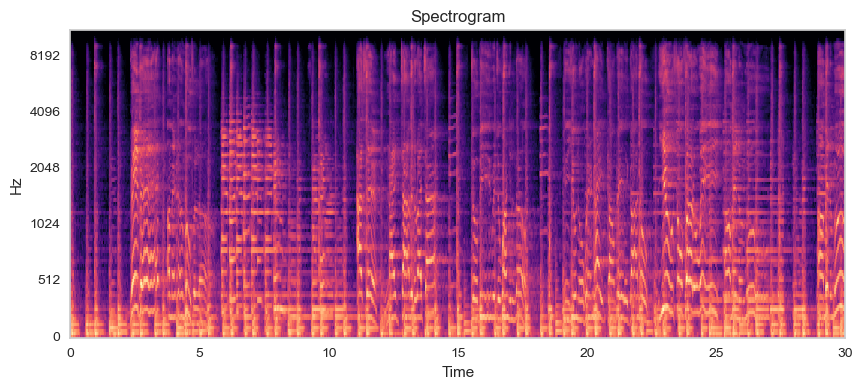

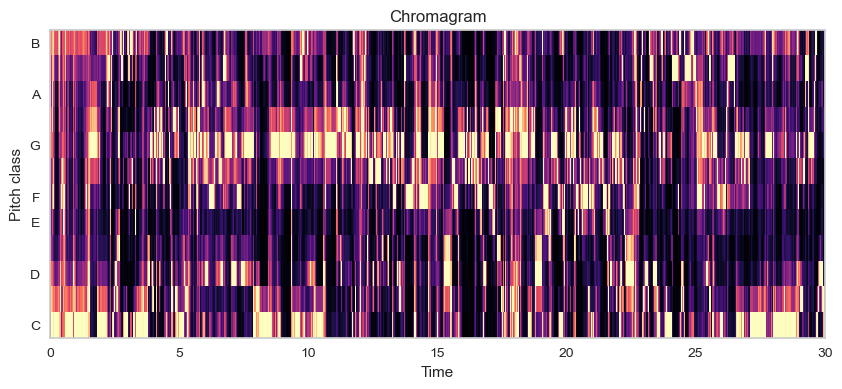

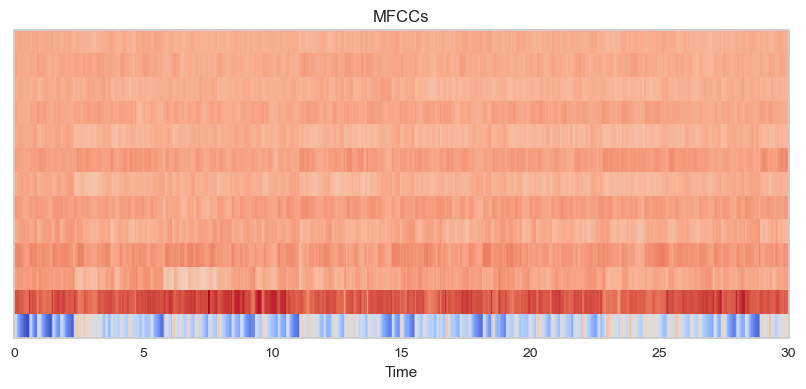

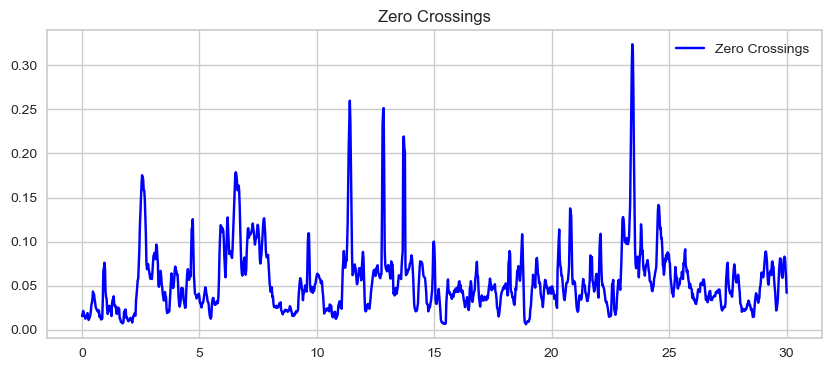

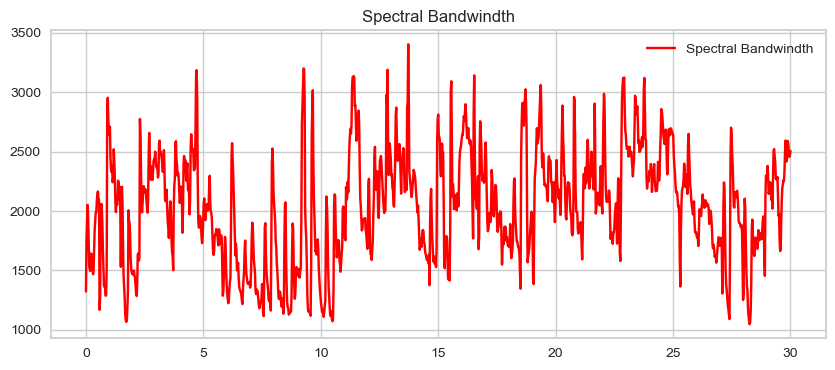

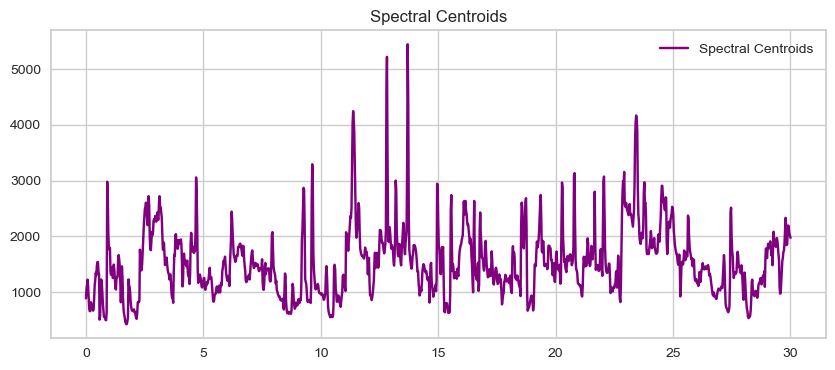

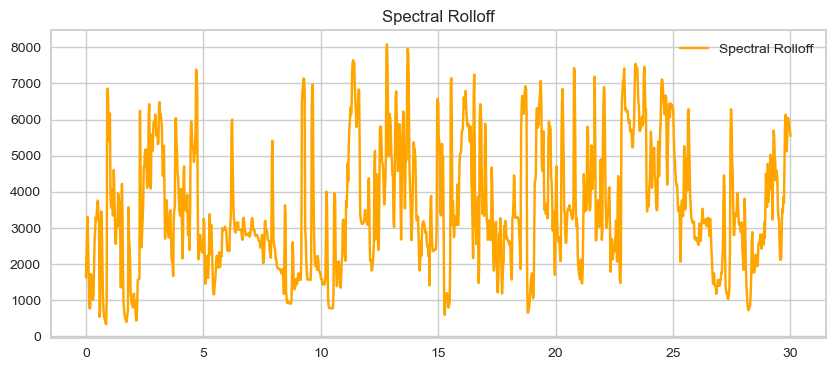

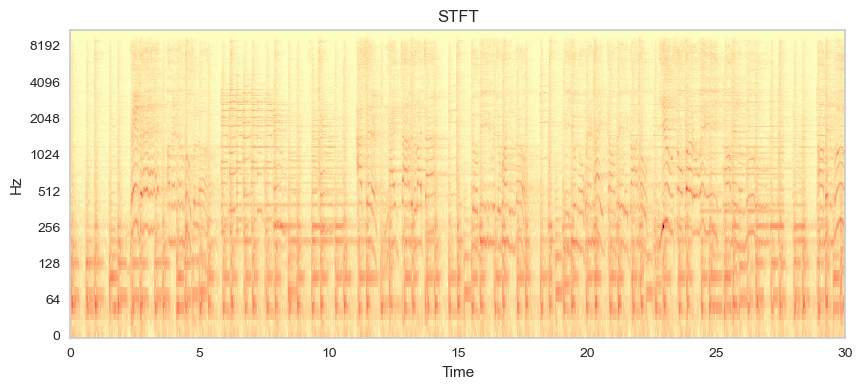

In [125]:

visualize_features(all_spectrograms[1], all_chromagrams[1], all_mfccs[1], all_zero_crossings[1], tempo, all_spectral_centroids[1], all_spectral_bw[1], all_spectral_rolloffs[1], all_stfts[1],all_srs[1])


In [286]:
#exctract the usefull features(means and var)

spectro_means=[]
spectro_var=[]
for spectro in all_spectrograms:
    spectro_means.append(spectro.mean())
    spectro_var.append(spectro.var())
                       
chroma_means=[]
chroma_var=[]
for chroma in all_chromagrams:
    chroma_means.append(chroma.mean())
    chroma_var.append(chroma.var())
    
                       
mfcc_means=[]
mfcc_var=[]
for mfcc in all_mfccs:
    mfcc_means.append(mfcc.mean())
    mfcc_var.append(mfcc.var())
                       
tempo_means=[]
tempo_var=[]
for tempo in all_tempos:
    tempo_means.append(tempo.mean())
    tempo_var.append(tempo.var())
                    
                
zero_crossing_means=[]
zero_crossing_var=[]
for zero_crossing in all_zero_crossings:
    zero_crossing_means.append(zero_crossing.mean())
    zero_crossing_var.append(zero_crossing.var())
                    
spectral_centroid_means=[]
spectral_centroid_var=[]
for spectral_centroid in all_spectral_centroids:
    spectral_centroid_means.append(spectral_centroid.mean())
    spectral_centroid_var.append(spectral_centroid.var())
                       
spectral_bw_means=[]
spectral_bw_var=[]
for spectral_bw in all_spectral_bw:
    spectral_bw_means.append(spectral_bw.mean())
    spectral_bw_var.append(spectral_bw.var())
    
spectral_rolloff_means=[]
spectral_rolloff_var=[]
for spectral_rolloff in all_spectral_rolloffs:
    spectral_rolloff_means.append(spectral_rolloff.mean())
    spectral_rolloff_var.append(spectral_rolloff.var())

stft_means=[]
stft_var=[]
for stft in all_stfts:
    stft_means.append(stft.mean())
    stft_var.append(stft.var())


In [309]:

all_mean_mfccs =np.zeros((13,1000))
all_var_mfccs = np.zeros((13,1000))

for i in range(13):
    # List to store mean for each coefficient
    mean_coefficient = []
    var_coefficient=[]
    
    for j in range(1000):
        mean_val = np.mean(all_mfccs[j][i, :])
        var_val= np.mean (all_mfccs[j][i, :])
        mean_coefficient.append(mean_val)
        var_coefficient.append(var_val)
        
    mean_coefficient=np.array(mean_coefficient)
    var_coefficient=np.array(var_coefficient)
    all_mean_mfccs[i]=mean_coefficient
    all_var_mfccs[i]=var_coefficient


In [310]:
#enumerate_labels
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
        'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

genres_numerical = [genres[genre] for genre in all_labels]
genres_numerical=np.array(genres_numerical)
print(genres_numerical.shape)


(1000,)


In [ ]:
data_names = ['genres_numerical', 'spectro_means', 'spectro_var', 'mfccs_means', 'mfccs_var',
                 'tempo_means', 'tempo_var', 'zero_crossing_means', 'zero_crossing_var',
                 'spectral_centroid_means', 'spectral_centroid_var', 'spectral_bw_means', 'spectral_bw_var',
                 'spectral_rolloff_means', 'spectral_rolloff_var', 'stft_means', 'stft_var']

# Add feature names for each MFCC coefficient mean and variance
for i in range(1, 14):  
    data_names.extend([f'mfccs_{i}_mean', f'mfccs_{i}_var'])

# Print the resulting list of feature names
print(data_names.shape)

In [323]:
#data_framing
data=np.stack([genres_numerical,spectro_means,spectro_var,mfcc_means,mfcc_var,tempo_means,tempo_var,zero_crossing_means,zero_crossing_var,spectral_centroid_means,spectral_centroid_var,spectral_bw_means,spectral_bw_var,spectral_rolloff_means,spectral_rolloff_var,stft_means,stft_var],axis=1)
dt=np.concatenate((data,np.transpose(all_mean_mfccs),np.transpose(all_var_mfccs)),axis=1)
df = pd.DataFrame(dt)
df.columns = data_names
ft = df.drop(columns=['genres_numerical'])
labels=df['genres_numerical']

In [330]:
#getting_ready_for_use
scaler=StandardScaler()
features_scaled= scaler.fit_transform(ft)
features = pd.DataFrame(features_scaled)
features.columns = ft.columns


In [329]:
features

,spectro_means,spectro_var,mfccs_means,mfccs_var,tempo_means,tempo_var,zero_crossing_means,zero_crossing_var,spectral_centroid_means,spectral_centroid_var,...,mfccs_9_mean,mfccs_9_var,mfccs_10_mean,mfccs_10_var,mfccs_11_mean,mfccs_11_var,mfccs_12_mean,mfccs_12_var,mfccs_13_mean,mfccs_13_var
0,-0.166102,-0.302190,0.459557,-0.343201,0.093947,0.0,-0.492045,-0.734349,-0.583830,-0.848433,...,0.364650,-0.426837,0.337008,-0.862381,0.499118,-0.637486,0.408516,-0.337964,0.645106,0.182840
1,-0.538385,-0.368719,0.046852,0.465219,-0.641904,0.0,-1.138098,-0.509142,-0.938604,-0.233866,...,-0.025408,0.332241,0.581853,-0.344700,1.266987,-0.375311,0.525521,0.068176,0.135019,0.415591
2,0.428067,-0.282295,0.491587,-0.308080,1.933573,0.0,-0.653615,-0.654970,-0.907061,-0.781712,...,-0.276397,-1.050211,0.939655,-0.858884,0.144831,-0.577582,0.250183,-1.042338,0.196597,-0.665506
3,0.208261,0.298444,0.162215,0.448493,2.448668,0.0,-1.681901,-0.848243,-1.581610,-0.712072,...,-0.566468,0.238949,-0.033892,0.030603,-0.079633,0.753670,0.050995,0.414370,0.239325,0.376035
4,-0.653322,-0.389072,-1.225322,0.033127,0.713610,0.0,-0.051477,-0.341504,-0.512549,-0.315418,...,-0.849612,-2.564542,-0.319670,-1.833719,-0.920430,-0.579782,-0.822597,-1.036415,-1.084760,-0.346486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.790320,-0.409002,-0.085532,-0.104125,-0.847942,0.0,-0.344135,-0.556394,-0.270716,-0.468089,...,1.364326,-0.521659,0.430518,-1.143033,0.760957,-1.837825,0.967865,-0.932750,1.173253,-1.218111
996,-0.806066,-0.409850,-0.150867,-0.141077,-0.173635,0.0,-0.142299,-0.701063,-0.272598,-0.717639,...,0.769765,-0.592838,0.697255,-1.327145,0.955272,-1.824547,0.386015,-1.023662,1.431837,-1.880131
997,-0.802183,-0.410478,-0.162943,-0.245053,0.388287,0.0,0.435653,-0.426648,-0.173740,-0.593861,...,0.992438,-1.010673,0.601440,-0.733336,0.956859,-1.374111,0.301719,-1.470898,0.894655,-2.133523
998,-0.699145,-0.394521,-0.205394,0.725501,-0.417949,0.0,-1.313111,-0.720917,-1.122533,-0.572167,...,1.220195,0.947259,0.507808,-0.516038,0.521253,-0.150268,0.640159,-0.437827,0.479240,-0.857134


**GRIDSEARCH FOR BEST CLASSIFIER:**

In [331]:
# Reset the index of the DataFrame
features_reset = features.reset_index(drop=True)

# Shuffle
shuffled_indices = np.arange(features_reset.shape[0])
np.random.shuffle(shuffled_indices)
shuffled_features = features_reset.iloc[shuffled_indices]
shuffled_labels = labels.iloc[shuffled_indices]

# Split the shuffled data for all models
X_train, X_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.3, random_state=42)

Best Random Forest Classifier: {'max_depth': 100, 'min_samples_split': 5, 'n_estimators': 200}
Best Accuracy: 0.61


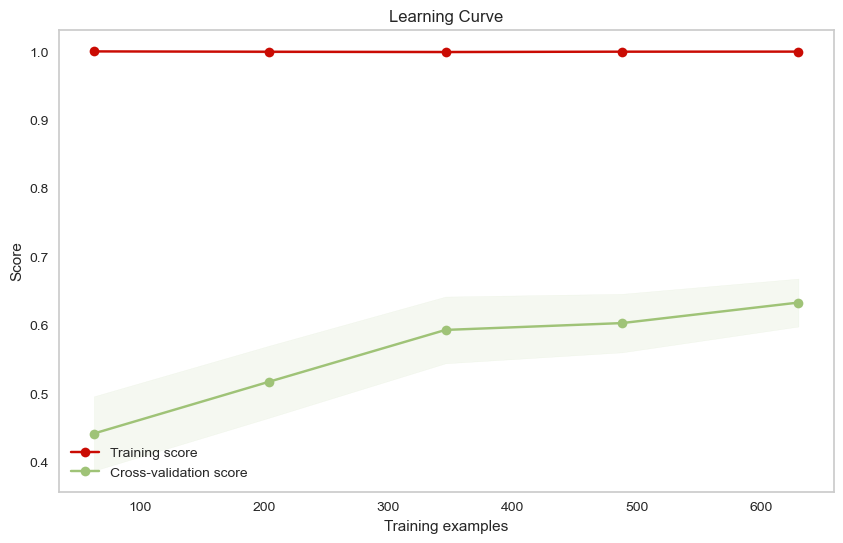

In [332]:
#Gridsearch Random Forest C
rf_classifier = RandomForestClassifier()

param_grid = {
    'n_estimators': [10,20,50,100,150,200],
    'max_depth': [None,10,20,50,100],
    'min_samples_split': [5,10,20,40,50,70,100],
    }

grid_search = GridSearchCV(rf_classifier, param_grid, cv=6, scoring='accuracy')
grid_search.fit(X_train, y_train)



Best Random Forest Classifier: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Best Accuracy: 0.6433333333333333


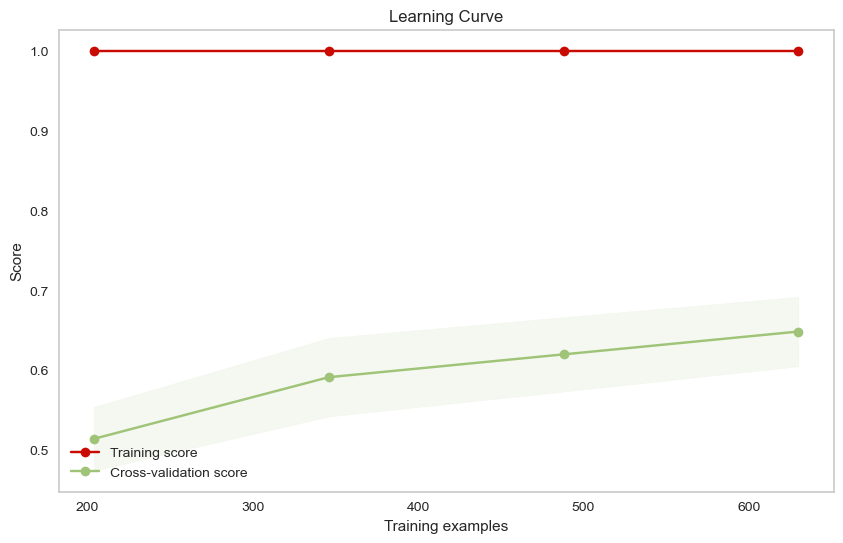

Text(72.31597222222221, 0.5, 'True Values')

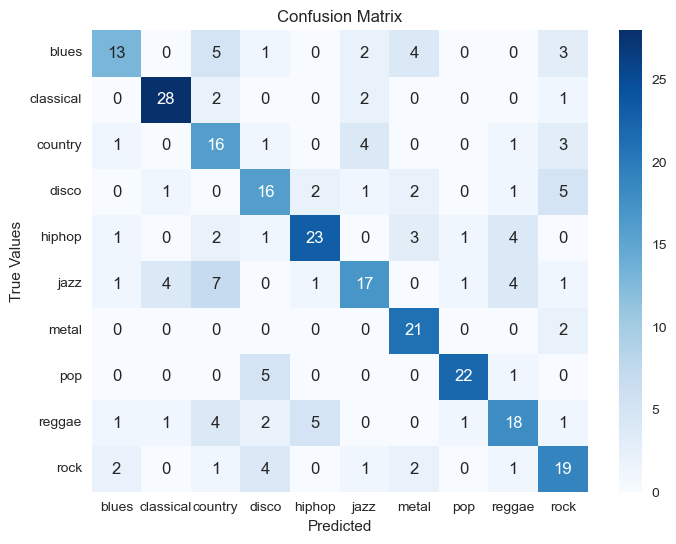

In [352]:
best_rf_classifier = grid_search.best_estimator_
best_rf_score = grid_search.best_score_
y_pred = best_rf_classifier.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Best Random Forest Classifier: {grid_search.best_params_}')
print(f'Best Accuracy: {accuracy}')

plot_learning_curve(best_rf_classifier, X_train, y_train, cv=10, n_jobs=-1)
plt.show()

cm = confusion_matrix(y_test, y_pred)
class_names = np.unique(all_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True Values')

In [363]:
#Gridsearch Support Vector Classifier

SVM_classifier = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100,150,200],       # Regularization parameter
    'kernel': ['linear', 'rbf','poly'],   # Kernel function
    'gamma': ['scale', 'auto'],           # Kernel coefficient (for 'rbf' and 'poly')
    'degree': [2, 3, 4]                   # Degree of the polynomial kernel (for 'poly')
}

grid_search = GridSearchCV(SVM_classifier, param_grid, cv=6, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_SVM_classifier = grid_search.best_estimator_

y_pred = best_SVM_classifier.predict(X_test)
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
best_SVM_score=accuracy

print(f'Best Random SVC Classifier: {grid_search.best_params_}')
print(f'Best Accuracy: {accuracy}')

plot_learning_curve(best_SVM_classifier, X_train, y_train, cv=6, n_jobs=-1)
plt.show()


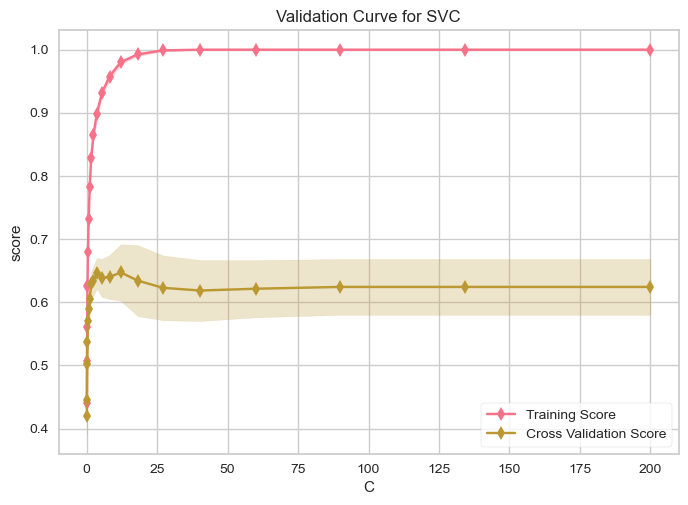

<Axes: title={'center': 'Validation Curve for SVC'}, xlabel='C', ylabel='score'>

In [375]:
# Validation curve for SVC
pr = np.logspace(np.log10(0.1),np.log10(200),20)
model = ValidationCurve(SVC(), param_name="C", param_range=pr)
model.fit(X_train, y_train)
model.show()

Accuracy: 0.71


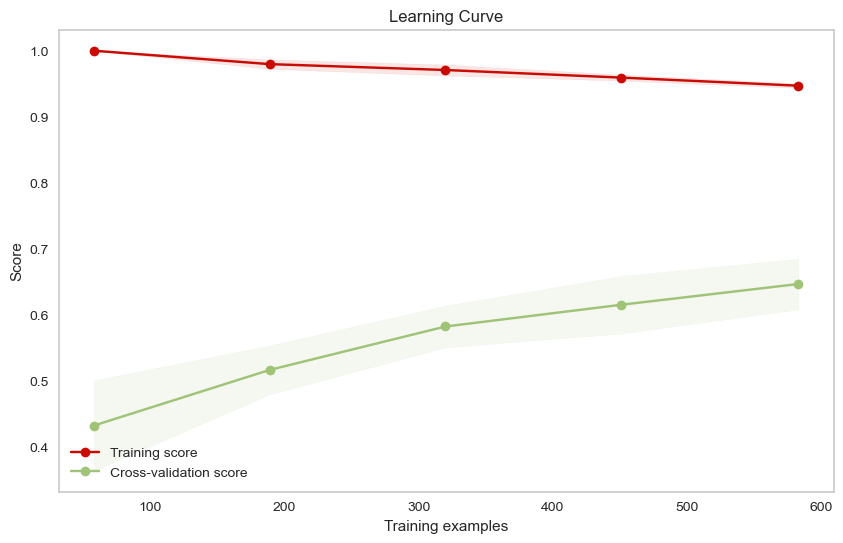

In [390]:
SVC_best_C=SVC(C=7,kernel='rbf')
SVC_best_C.fit(X_train,y_train)
y_pred = SVC_best_C.predict(X_test)
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

plot_learning_curve(SVC_best_C, X_train, y_train, cv=6, n_jobs=-1)
plt.show()

Text(72.31597222222221, 0.5, 'True Values')

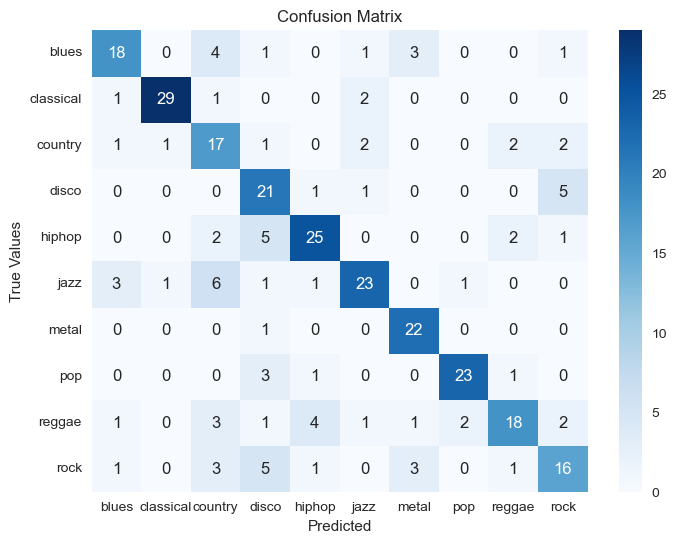

In [366]:
# Confusion matrix for SVC
cm = confusion_matrix(y_test, y_pred)
class_names = np.unique(all_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True Values')

Accuracy: 0.5633333333333334


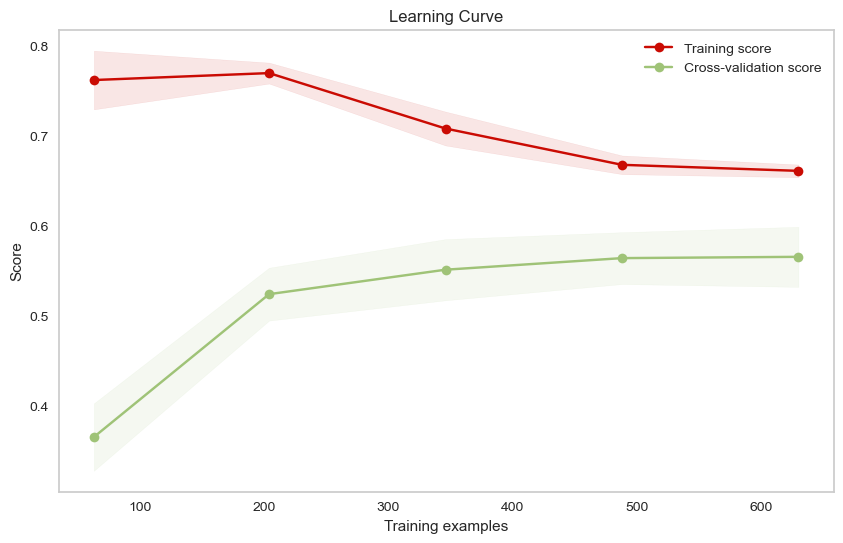

In [336]:
# Adaboost in one weak SVC model

weak_learner = SVC(probability=True, kernel='rbf', C=200)
adaboost_model = AdaBoostClassifier(estimator=weak_learner, n_estimators=1, random_state=42)

adaboost_model.fit(X_train, y_train)

predictions = adaboost_model.predict(X_test)
adaboost_svm_score = adaboost_model.score(X_test, y_test)
print(f"Accuracy: {adaboost_svm_score}")

plot_learning_curve(adaboost_model, X_train, y_train, cv=10, n_jobs=-1)
plt.show()

Best KNN Classifier: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy: 0.647116612633854


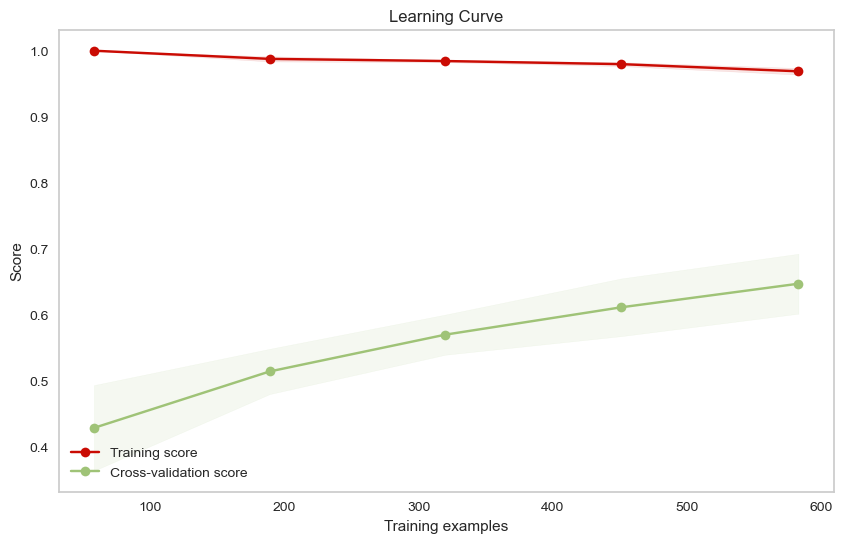

In [337]:
# Gridsearch KNN
from sklearn.model_selection import GridSearchCV, cross_val_score


param_grid = {'n_neighbors': [5, 10, 15, 20, 25],
              'p': [1, 2, 3],
              'weights': ['uniform', 'distance']}

KNN_grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

KNN_grid_search.fit(X_train, y_train)
best_KNN_classifier = grid_search.best_estimator_
best_KNN_score = grid_search.best_score_
y_pred = best_KNN_classifier.predict(X_test)

print(f'Best KNN Classifier: {grid_search.best_params_}')
print(f'Best Accuracy: {best_KNN_score}')

plot_learning_curve(best_KNN_classifier, X_train, y_train, cv=6, n_jobs=-1)
plt.show()

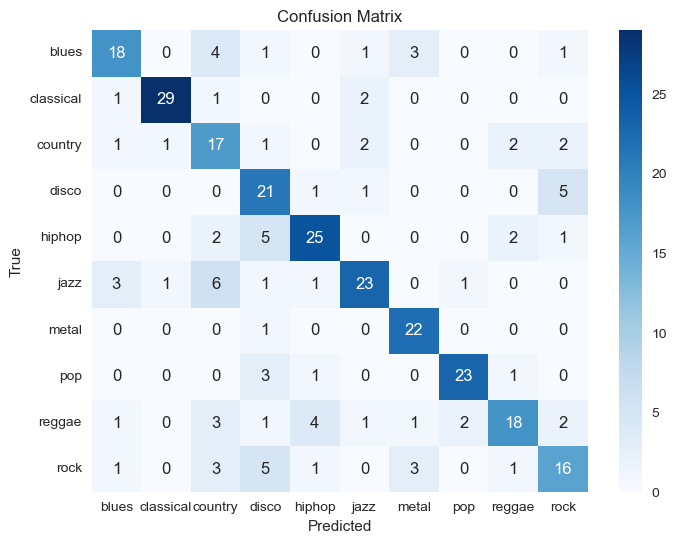

In [338]:
# Confustion matrix for KNN
cm = confusion_matrix(y_test, y_pred)
class_names = np.unique(all_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [346]:
# Feature names for XGB
ft_names=['spectro_means', 'spectro_var', 'mfccs_means', 'mfccs_var',
       'tempo_means', 'tempo_var', 'zero_crossing_means', 'zero_crossing_var',
       'spectral_centroid_means', 'spectral_centroid_var', 'spectral_bw_means',
       'spectral_bw_var', 'spectral_rolloff_means', 'spectral_rolloff_var',
       'stft_means', 'stft_var', 'mfccs_1_mean', 'mfccs_1_var', 'mfccs_2_mean',
       'mfccs_2_var', 'mfccs_3_mean', 'mfccs_3_var', 'mfccs_4_mean',
       'mfccs_4_var', 'mfccs_5_mean', 'mfccs_5_var', 'mfccs_6_mean',
       'mfccs_6_var', 'mfccs_7_mean', 'mfccs_7_var', 'mfccs_8_mean',
       'mfccs_8_var', 'mfccs_9_mean', 'mfccs_9_var', 'mfccs_10_mean',
       'mfccs_10_var', 'mfccs_11_mean', 'mfccs_11_var', 'mfccs_12_mean',
       'mfccs_12_var', 'mfccs_13_mean', 'mfccs_13_var']

Accuracy: 0.6266666666666667


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

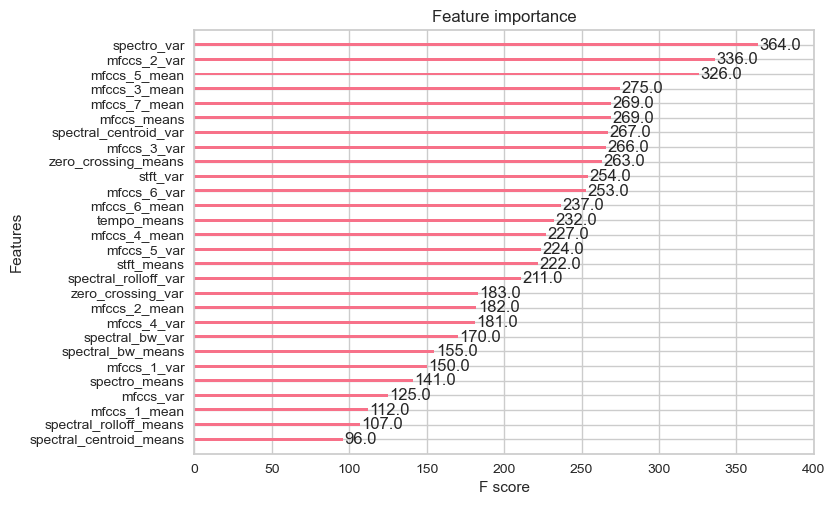

In [347]:
# XGB Classifier Feature Importance

num_classes=len(labels)
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=num_classes, eval_metric='mlogloss')
xgb_classifier.fit(X_train, y_train)


y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
xgb_classifier.get_booster().feature_names = ft_names
xgb.plot_importance(xgb_classifier.get_booster())



Best Parameters:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Best Score:  0.6284924739860362


<module 'matplotlib.pyplot' from 'C:\\Users\\HP\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

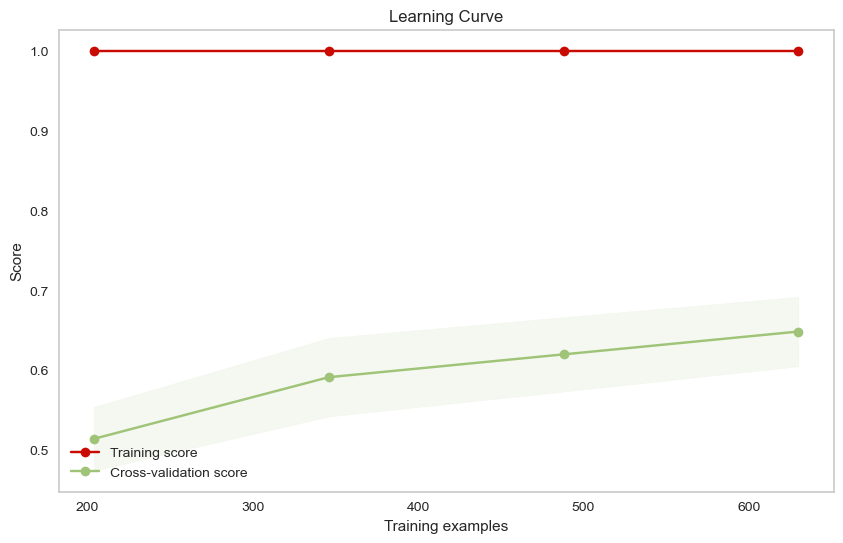

In [348]:
# Gradient Search For XGBOOST classifier
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5]
}
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='accuracy', cv=3)

grid_search.fit(X_train, y_train)

# Print Best Parameters and Best Score
print("Best Parameters: ", grid_search.best_params_)
best_xgb_score = grid_search.best_score_
best_xgb_classifier=grid_search.best_estimator_
print("Best Score: ", best_xgb_score)
plot_learning_curve(best_xgb_classifier, X_train, y_train, cv=10, n_jobs=-1)


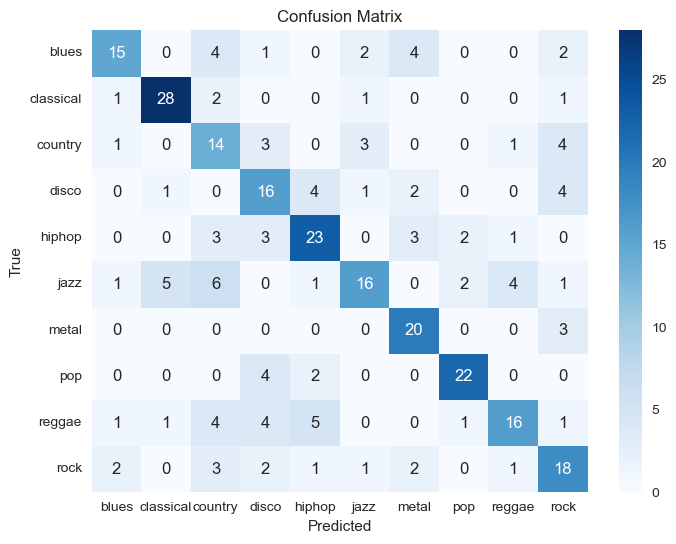

In [349]:
# Confusion Matrix for XGB
cm = confusion_matrix(y_test, y_pred)
class_names = np.unique(all_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [369]:
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=num_classes,early_stopping_rounds=5, eval_metric='mlogloss',colsample_bytree= 0.8, gamma= 0, learning_rate= 0.1, max_depth= 7, n_estimators= 100, subsample= 0.8)

# Fit the classifier on the training data with validation set
xgb_classifier.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],  
    verbose=True
)

# Make predictions on the test data
y_pred = xgb_classifier.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
best_xgb_score=accuracy
print(f"Accuracy: {accuracy}")

[0]	validation_0-mlogloss:2.15463
[1]	validation_0-mlogloss:2.03312
[2]	validation_0-mlogloss:1.94408
[3]	validation_0-mlogloss:1.86827
[4]	validation_0-mlogloss:1.80309
[5]	validation_0-mlogloss:1.74661
[6]	validation_0-mlogloss:1.69599
[7]	validation_0-mlogloss:1.64658
[8]	validation_0-mlogloss:1.60847
[9]	validation_0-mlogloss:1.57325
[10]	validation_0-mlogloss:1.53546
[11]	validation_0-mlogloss:1.50386
[12]	validation_0-mlogloss:1.47421
[13]	validation_0-mlogloss:1.44162
[14]	validation_0-mlogloss:1.41656
[15]	validation_0-mlogloss:1.39086
[16]	validation_0-mlogloss:1.37068
[17]	validation_0-mlogloss:1.35045
[18]	validation_0-mlogloss:1.33528
[19]	validation_0-mlogloss:1.31605
[20]	validation_0-mlogloss:1.29965
[21]	validation_0-mlogloss:1.28264
[22]	validation_0-mlogloss:1.26704
[23]	validation_0-mlogloss:1.25226
[24]	validation_0-mlogloss:1.23926
[25]	validation_0-mlogloss:1.22752
[26]	validation_0-mlogloss:1.21379
[27]	validation_0-mlogloss:1.20088
[28]	validation_0-mlogloss:1.1

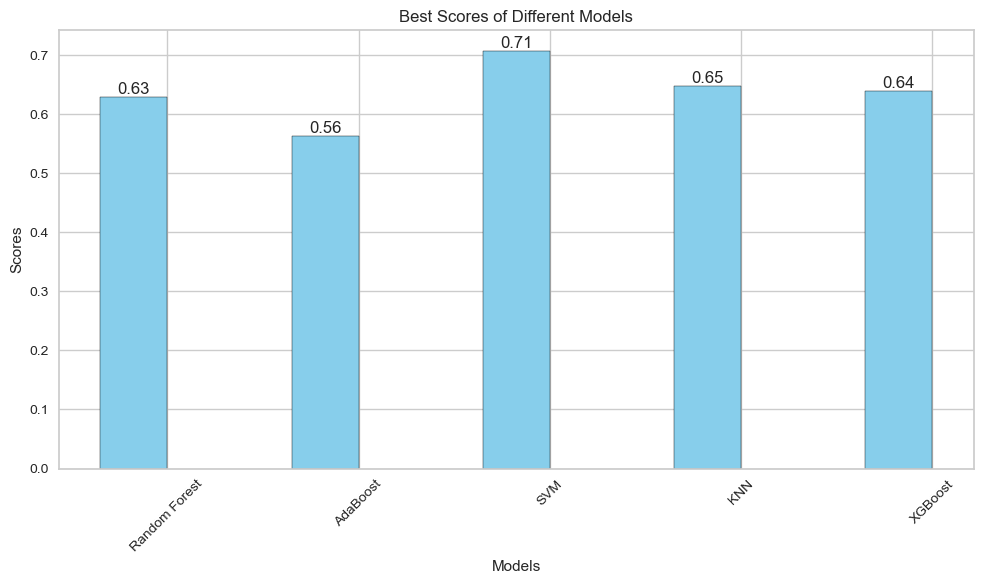

In [370]:
# Define the model names and their corresponding scores
model_names = ['Random Forest', 'AdaBoost', 'SVM', 'KNN', 'XGBoost']
best_scores = [best_rf_score, adaboost_svm_score, best_SVM_score, best_KNN_score, best_xgb_score]

# Set the width of the bars
bar_width = 0.35

# Calculate the positions for the bars
index = np.arange(len(model_names))

# Define the colors
best_scores_color = 'skyblue'
mean_scores_color = 'mistyrose'

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(index, best_scores, bar_width, label='Best Scores', color=best_scores_color, edgecolor='black')

# Add value labels above each bar
for i in range(len(index)):
    plt.text(i, best_scores[i], round(best_scores[i], 2), ha='center', va='bottom')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Best Scores of Different Models')
plt.xticks(index + bar_width/2, model_names, rotation=45)
plt.tight_layout()
plt.show()

In [361]:
# Random guessing accuracy

unique_classes = np.unique(y_train)
random_predictions = np.random.choice(unique_classes, size=len(y_test))
accuracy = accuracy_score(y_test, random_predictions)
print(f'Random Guess Accuracy: {accuracy}')

Random Guess Accuracy: 0.12
